<h2 style="text-align:center;">Custom RAG Agent</h2>

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Zoomable Image</title>
    <style>
        body {
            margin: 0;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 20vh;
            background-color: #f0f0f0;
        }
        #graph {
            width: 30%;
            height: auto;
        }
    </style>
    <script src="https://unpkg.com/@panzoom/panzoom@9.4.0/dist/panzoom.min.js"></script>
</head>
<body>
    <div id="graph-container">
        <center><img id="graph" src="./data/rag_agent_langgraph.png" alt="Language Graph"></center>
    </div>
    <script>
        const element = document.getElementById('graph');
        const panzoom = Panzoom(element, {
            maxScale: 3,
            minScale: 0.5
        });
        element.parentElement.addEventListener('wheel', panzoom.zoomWithWheel);
    </script>
</body>
</html>


#### Steps to be followed:

    1️⃣ Preprocess a document and create text chunks ready for retrieval.
    2️⃣ Build a classification node that decides whether to use a retriever tool or just directly respond to the user.
    3️⃣ Create a retriever using LangChain’s InMemoryVectorStore.
    4️⃣ Add a grading node to evaluate which retrieved documents are truly relevant — and here’s where we’ll use Send API for parallel grading and our Reducer Function to combine the results.
    5️⃣ If no relevant documents are found, we’ll have the agent rewrite the user’s query using an LLM to improve retrieval.
    6️⃣ And finally, we’ll generate a response using the LLM, combining the user’s question and the relevant context we’ve gathered.

#### Preprocess Document

In [1]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
docs = WebBaseLoader("https://huggingface.co/blog/vibegame").load()

In [3]:
docs_list = [item for item in docs]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)

doc_splits = text_splitter.split_documents(docs_list)

In [4]:
len(doc_splits), doc_splits[0]

(8,
 Document(metadata={'source': 'https://huggingface.co/blog/vibegame', 'title': 'VibeGame: Exploring Vibe Coding Games', 'description': 'We’re on a journey to advance and democratize artificial intelligence through open source and open science.', 'language': 'No language found.'}, page_content='VibeGame: Exploring Vibe Coding Games\n\n\n\n \n\n\n\nHugging Face\n\n\n\n\n\n\n\n\t\t\t\t\t\tModels\n\n\t\t\t\t\t\tDatasets\n\n\t\t\t\t\t\tSpaces\n\n\n\n\t\t\tCommunity\n\t\t\n\n\n\t\t\t\t\t\tDocs\n\n\t\t\t\t\t\tEnterprise\n\nPricing\n\t\t\t\n\n\n\n\n\n\nLog In\n\t\t\t\t\nSign Up\n\t\t\t\t\t\n\n\n\n\t\t\t\t\t\t\tBack to Articles\n\n\n\n\n\n\t\tVibeGame: Exploring Vibe Coding Games\n\t\n\n\nPublished\n\t\t\t\tSeptember 29, 2025\nUpdate on GitHub\n\n\n\n\t\tUpvote\n\n\t\t25\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n+19\n\n\n\n\n\nDylan Ebert\n\ndylanebert\n\n\n\nFollow\n\n\n\n\n\n\n\n\n\n\nThe Problem\n\nWhat Is "Vibe Coding"?\n\nContext Management\n\nInitial Exploration\nAttempt 1: Roblox MCP\n\nAttempt 2

#### Classification

In [5]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
import os

In [6]:
llm = ChatOpenAI(temperature=0, model="gpt-4.1-nano", api_key=os.environ["OPENAI_API_KEY"]) # type: ignore

In [7]:
CLASSIFICATION_PROMPT = (
    "You are a classifier, given the current state, you will decide to retrieve from the retriever tool, or simply respond to the user if question is general.\n"
    "Here is the current state: {state} \n"
)

class Classify(BaseModel):
    """Classify based on the users input."""

    result: str = Field(
        description="Return 'retrieve' if need to retrieve from retriever tool, else return 'response' directly"
    )

def generate_query_or_respond(state):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve from the retriever tool, or simply respond to the user.
    """
    state = state["messages"]

    prompt = CLASSIFICATION_PROMPT.format(state=state)

    response = (
        llm.with_structured_output(Classify).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    return {"messages" : response.result} # type: ignore


#### Retriever 

In [8]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

In [9]:
embedding=OpenAIEmbeddings(model="text-embedding-3-small", api_key = os.environ['OPENAI_API_KEY']) # type: ignore

In [10]:
embedding.embed_query("hi")

[-0.0037857908755540848,
 -0.019175462424755096,
 0.012144993990659714,
 0.03277144208550453,
 0.016249440610408783,
 -0.03722861409187317,
 -0.028266169130802155,
 0.06496569514274597,
 0.0009970518294721842,
 -0.05752638727426529,
 0.0014469778398051858,
 -0.03273937478661537,
 -0.030767317861318588,
 0.004797873552888632,
 0.032963838428258896,
 0.019223561510443687,
 -0.04194231331348419,
 -0.0029721164610236883,
 0.024674778804183006,
 0.04662394896149635,
 0.03780580312013626,
 0.0341823436319828,
 -0.0024610646069049835,
 0.03623456880450249,
 0.016385721042752266,
 0.0018638356123119593,
 0.002152429660782218,
 -0.008826163597404957,
 0.03209805488586426,
 -0.026406342163681984,
 0.0014008829602971673,
 -0.0377737358212471,
 0.02578105591237545,
 -0.037036217749118805,
 -0.01654605008661747,
 -0.012609950266778469,
 -0.025588659569621086,
 0.03306003659963608,
 0.015503905713558197,
 -0.0377737358212471,
 0.025059571489691734,
 -0.004962211940437555,
 0.04639948904514313,
 0.01

In [12]:
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits, embedding=embedding
    )
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 3})

In [13]:
retriever.invoke("what is vibe coding?")

[Document(id='7356ee50-0599-4083-a98e-15959b6e5c55', metadata={'source': 'https://huggingface.co/blog/vibegame', 'title': 'VibeGame: Exploring Vibe Coding Games', 'description': 'We’re on a journey to advance and democratize artificial intelligence through open source and open science.', 'language': 'No language found.'}, page_content='What Is "Vibe Coding"?\n\t\n\nFirst, what is vibe coding? It\'s originally coined by Andrej Karpathy in a viral tweet where it\'s defined as where you "fully give in to the vibes, embrace exponentials and forget the code even exists".\nHowever, since then, it\'s used descriptively to mean a lot of different things, anywhere from just "using AI when coding" to "not thinking about the code at all". In this blog post, I\'ll define it as: using AI as a high-level programming language to build something. Like other programming languages, this benefits from understanding what\'s going on under the hood, but doesn\'t necessarily require it.\nWith this interpret

In [14]:
def vector_search(state):
    """Fetch context using the retriever tool."""

    question = state["messages"][-2].content
    print("Query for vector store search: ", question)
    context = retriever.invoke(question)
    return {"context": context}

#### Grade Documents

In [15]:
GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)

class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

In [16]:
def grade_documents(state):
    # print("State in grade_documents:", state)
    question = state["question"]
    context = state["context"]
    """Determine whether the retrieved documents are relevant to the question."""
    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        llm.with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )

    print("Grading response binary score:", response.binary_score) # type: ignore
    if response.binary_score == "yes": # type: ignore
        return {"validated_context" :[context]}
    else:
        return {"validated_context" : []}

In [17]:
from langgraph.types import Send

def context_reducer(state):
    question = state["messages"][0].content
    response = state["context"]

    return [Send("grade_documents", {"question": question, "context": doc.page_content}) for doc in response]


#### Rewrite User's Question

In [18]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

In [19]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use 4-5 sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)

#### Generate Final Answer

In [20]:
def generate_answer(state):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["validated_context"]

    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

#### Assemble the Graph

In [21]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image # type: ignore

from typing import Annotated
from langchain_core.messages import HumanMessage
from langchain_core.documents.base import Document
from operator import add
from langgraph.graph import MessagesState
from typing import Literal

In [22]:
class GraphState(MessagesState):
    validated_context: Annotated[list[Document], add]
    retry_counter: int

In [23]:
def retriever_condition(state) -> Literal["retrieve", "response"]:
    # print(state)
    if state["messages"][-1].content == "retrieve":
        return "retrieve"
    return "response"

In [24]:
def validate_context(state) -> Literal["rewrite_question", "response"]:

    print("Retry Counter: ", state["retry_counter"])
    if len(state["validated_context"]) == 0:  
        if state["retry_counter"] >= 2:
            return "generate_answer" # type: ignore
        return "rewrite_question"
    
    return "generate_answer" # type: ignore

In [25]:
def collect_docs(state):
    
    return {"retry_counter" : state["retry_counter"] + 1}

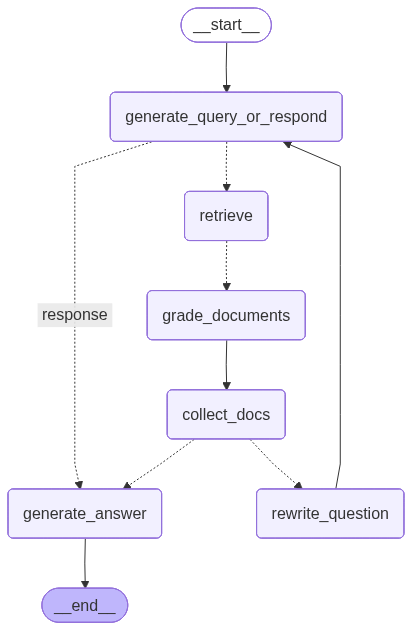

In [26]:
workflow = StateGraph(GraphState)

workflow.add_node("generate_query_or_respond", generate_query_or_respond)
workflow.add_node("retrieve", vector_search)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("rewrite_question", rewrite_question)
workflow.add_node("collect_docs", collect_docs)

workflow.add_edge(START, "generate_query_or_respond")
workflow.add_conditional_edges(
    "generate_query_or_respond",
    retriever_condition
    ,
    {
        "retrieve": "retrieve",
        "response": "generate_answer",
    },
)

workflow.add_conditional_edges("retrieve", context_reducer, ["grade_documents"])
workflow.add_edge("grade_documents", "collect_docs")
workflow.add_conditional_edges(
    "collect_docs",
    validate_context
    ,
    {
        "rewrite_question": "rewrite_question",
        "generate_answer": "generate_answer",
    },
)
workflow.add_edge("rewrite_question", "generate_query_or_respond")
workflow.add_edge("generate_answer", END)


graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

#### Test it Out

In [27]:
res = graph.invoke({"messages": [HumanMessage(content="What is vibe coding according to the blog?") ], 'retry_counter' : 0})  # type: ignore
print("Final Response: ", res['messages'][-1].content)

Query for vector store search:  What is vibe coding according to the blog?
Grading response binary score: yes
Grading response binary score: yes
Grading response binary score: no
Retry Counter:  1
Final Response:  Vibe coding, as defined in the blog, is using AI as a high-level programming language to build projects, embracing the "vibes" and not necessarily focusing on understanding the underlying code. It involves fully giving in to the process, often neglecting traditional coding details, and relies on AI to generate or manage the code. While understanding fundamentals can help, vibe coding allows for creating complex projects without deep coding knowledge. Essentially, it emphasizes a more intuitive, AI-driven approach to programming.


In [30]:
res

{'messages': [HumanMessage(content='What is vibe coding according to the blog?', additional_kwargs={}, response_metadata={}, id='0d1144a7-0564-4c5c-aa3e-45e8e8e5649d'),
  HumanMessage(content='retrieve', additional_kwargs={}, response_metadata={}, id='4d062c4b-b248-40ac-b57d-c2de8fdf2cad'),
  AIMessage(content='Vibe coding, as defined in the blog, is using AI as a high-level programming language to build projects, embracing the "vibes" and not necessarily focusing on understanding the underlying code. It involves fully giving in to the process, often neglecting traditional coding details, and relies on AI to generate or manage the code. While understanding fundamentals can help, vibe coding allows for creating complex projects without deep coding knowledge. Essentially, it emphasizes a more intuitive, AI-driven approach to programming.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 98, 'prompt_tokens': 959, 'total_tokens': 1057, 'completi

In [28]:
out = graph.invoke({"messages": [HumanMessage(content="Hello, who are you?") ], "retry_counter" : 0})  # type: ignore
print("Final Response: ", out['messages'][-1].content)

Final Response:  Hello! I am an AI assistant here to help answer your questions and provide information. How can I assist you today?


In [29]:
out

{'messages': [HumanMessage(content='Hello, who are you?', additional_kwargs={}, response_metadata={}, id='a17088d8-d31e-41c5-b783-278ae3433ca3'),
  HumanMessage(content='response', additional_kwargs={}, response_metadata={}, id='6be9f498-03ad-444b-9eff-f3cb7e6f551b'),
  AIMessage(content='Hello! I am an AI assistant here to help answer your questions and provide information. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 68, 'total_tokens': 92, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_950f36939b', 'id': 'chatcmpl-CUVl655zLPcAcppHEJdnB5CFtuj59', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--3cc86f16-10eb-4129-bb87-2058455527f9-0',

In [ ]:
try:
    res = graph.invoke({"messages": [HumanMessage(content="Who won fifa world cup 2022? ")], "retry_counter" : 0}, {"recursion_limit": 10}) # type: ignore
    print("Final Response: ", res['messages'][-1].content)
except Exception as e:
    print(e)